### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 3
### Due: Saturday, Feb 10th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (50 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $1000$ bootstrap realizations of this dataset. *DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together.*

5) Repeat (2) with all $1000$ boostrap datasets to find the distribution of the sample mean. Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $1000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [1]:
!pip install numdifftools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 2.3 MB/s eta 0:00:00a 0:00:01


In [9]:
import numdifftools as nd
H = nd.Hessian(f_lnlaplace)([beta_laplace[0], beta_laplace[1]])
sigma_laplace = np.linalg.inv(H)**0.5

NameError: name 'f_lnlaplace' is not defined

### Solution

In [60]:
#import tools
import numpy as np
import matplotlib.pyplot as plt
import scipy


In [8]:
#load array
data = np.load('/home/nowickr/astr_8070_s24/coursework/homeworks/hw_data/hw3_data_1.npy')
print(data)

[[2.97207735 0.93806458]
 [1.98824293 1.40262692]
 [1.66981961 1.97120698]
 [3.96519709 0.60359301]
 [3.38541476 1.29698654]
 [4.24894584 1.68629961]
 [3.69290063 1.06277049]
 [4.33198366 1.28038671]
 [2.49401178 1.22485083]
 [1.89419429 1.40555012]
 [2.04203146 1.30841409]
 [4.15394176 1.97421998]
 [4.14130534 1.59510787]
 [4.21256076 1.4295954 ]
 [4.47047556 0.9776734 ]
 [4.29385594 1.47949413]
 [3.68668822 0.96958318]
 [4.67658913 1.53171867]
 [3.66326255 0.51330266]
 [3.86702391 0.69561611]
 [4.15062285 0.76745015]
 [5.10972749 1.94193392]
 [4.16180633 1.26347131]
 [4.04294769 1.50713396]
 [3.14447868 1.51402808]
 [6.13017327 1.67982047]
 [7.47431877 1.79210525]
 [4.55226549 0.70417746]
 [3.18937552 1.41750426]
 [5.05068215 1.59340252]
 [2.58504832 1.40936962]
 [3.2807617  0.7817426 ]
 [3.15074159 0.5165563 ]
 [4.68488632 0.67327222]
 [6.58112816 1.91096086]
 [2.8891109  1.63403368]
 [5.12723698 0.58202125]
 [4.42150207 0.86437187]
 [5.78739811 1.1488919 ]
 [3.09099302 0.99063548]


### Part 1

Equation for heteroscedastic Gaussian sample mean from Lecture 5: $$\hat \mu = \frac{\sum_i^N (x_i/\sigma_i^2)}{\sum_i^N (1/\sigma_i^2)}$$

In [18]:
#extracting columns from array
datval = data[:,0] #value
datunc = data[:,1] #uncertainty

#computing sample mean
datmean = np.sum(datval/(datunc**2)) / np.sum(1/(datunc**2))
print('Heteroscedastic Gaussian Mean of Provided Dataset:', datmean)

Heteroscedastic Gaussian Mean of Provided Dataset: 3.9179920346060557


Equation for heteroscedastic Gaussian uncertainty from Lecture 5: $$\sigma_{\mu} = \left( \sum_{i=1}^N \frac{1}{\sigma_i^2}\right)^{-1/2}$$

In [19]:
#standard error 
uncmean = (np.sum(1/(datunc**2)))**(-1/2)
print('Heteroscedastic Gaussian Uncertainty of Provided Dataset:', uncmean)

Heteroscedastic Gaussian Uncertainty of Provided Dataset: 0.09481084100510954


### Part 2

$$\ln L = {\rm constant} - \sum_{i=1}^N \frac{(x_i - \mu)^2}{2\sigma_i^2}.$$


$$z_i = (x_i-\mu)/\sigma,$$ 

then

$$\ln L = {\rm constant} - \frac{1}{2}\sum_{i=1}^N z_i^2 = {\rm constant} - \frac{1}{2}\chi^2.$$


In [39]:
#write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions
def lnL(val,unc,mu,const=0):
    const = const
    zi = (val-mu)/unc
    lnLG = const - (1/2)*np.sum(zi**2)
    return lnLG

lnL(datval,datunc,datmean)

-43.16254534646689

In [72]:
def lnL_mu_only(mu,const=0):
    const = const
    zi = (datval-mu)/datunc
    lnLGmu = const - (1/2)*np.sum(zi**2)
    #lnLGmu = lnLGmu.append([lnL])
    return lnLGmu


In [335]:
def lnL_mu_arr(data,mu,const=0):
    vals = data[:,0]
    sigs = data[:,1]
    const = const
    lnLma = const - (1/2)*np.sum((vals-mu)**2/(sigs**2))
    return lnLma

lnL_mu_arr(data,3)

-90.27674030590926

In [381]:
def lnL_mugrid(data,mu,const=0):
    lnLgrid=np.array([])
    const = const
    vals = data[:,0]
    sigs = data[:,1]
    for i in mu:
        lnLma = const - (1/2)*np.sum((vals-i)**2/(sigs**2))
        lnLgrid = np.append(lnLgrid,lnLma)
    return lnLgrid

Text(0, 0.5, 'ln Likelihood')

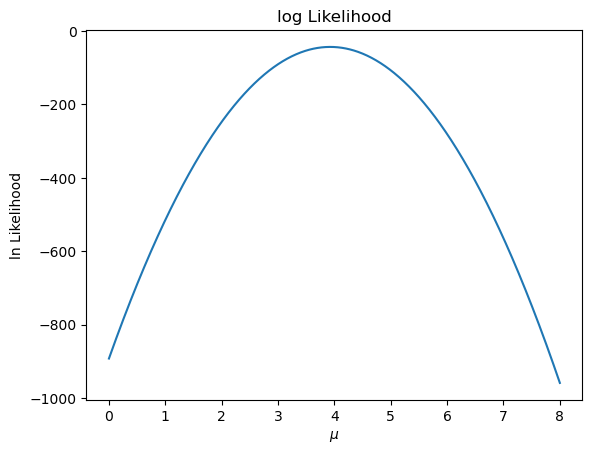

In [387]:
#use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions
xgrid = np.linspace(0,8,1000)
lnLplot = lnL_mugrid(data=data,mu=xgrid)

plt.plot(xgrid,lnLplot)
plt.title('log Likelihood')
plt.xlabel('$\mu$')
plt.ylabel('ln Likelihood')

In [390]:
#determining optimum mu
lnLmax = lnLplot.max()

muindex = np.where(lnLplot == lnLmax)

muopt = xgrid[muindex]

print('Maximum ln Likelihood:', lnLmax)
print('Optimum mu:', muopt)


Maximum ln Likelihood: -43.15435060385526
Optimum mu: [3.92392392]


### Part 3

The Fisher matrix elements are defined as follows:

$$ F_{jk} = - \frac{\partial^2}{\partial\theta_j} \frac{\ln L}{\partial\theta_k} \Biggr\rvert_{\theta=\hat \theta}$$


In [195]:
#compute the Fisher uncertainty matrix on the mean using the numerical method from lecture 5
F_jk = np.diff(lnLtest, n=2)    #second derivative in delta theta
#print(F_jk)

#method pulled straight from lecture 5: 
F_jk /= (xgrid[1]-xgrid[0])**2  #normalizing to delta theta
F_jk *= -1                      #multiply by -1
F_jk = 1/np.sqrt(F_jk)[0]       #take the square root

print('Fisher Information Matrix Error on the Mean:', F_jk)


Fisher Information Matrix Error on the Mean: 0.09481084100389774


### Part 4

In [419]:
#Using the bootstrap method, generate $1000$ bootstrap realizations of this dataset. *DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together.*
import random
n = 1000 #number of bootstraps
np.random.seed(21023) #for comparing solutions with Jaelyn

#databoots = np.random.shuffle(data)

#creating function to randomly select rows from data (basically resampling)
def resamp(data):
    newdata = []
    for i in range(len(data)):
        sampindex = random.randrange(len(data))
        sample = data[sampindex,:]
        print(sample)
        newdata.append(sample)
    return newdata
    

x = resamp(data)

print('New Bootstrapped Sample:', x)
#print(x[0])
#print(x[1])
#print(data[:6])

[4.56778994 1.07847601]
[0.93806458 2.97207735]
[7.47431877 1.79210525]
[3.13482852 1.78621005]
[2.04203146 1.30841409]
[3.14653177 0.77481835]
[0.93806458 2.97207735]
[2.94239726 1.48436902]
[0.41036839 1.52273128]
[4.16180633 1.26347131]
[4.94178893 1.07902421]
[2.45921984 1.25788577]
[3.08022213 1.01228358]
[5.61515858 1.54215483]
[3.46562245 0.88805017]
[2.58504832 1.40936962]
[3.15810998 0.51140379]
[3.91370395 1.54376768]
[0.93806458 2.97207735]
[4.77882139 1.62476338]
[4.6024919  0.78480243]
[3.13482852 1.78621005]
[4.53694361 1.92379373]
[7.47431877 1.79210525]
[5.78739811 1.1488919 ]
[4.04550675 0.59957146]
[4.39262812 1.76637912]
[6.78259445 1.37286052]
[3.46562245 0.88805017]
[2.8891109  1.63403368]
[4.24447507 0.5740388 ]
[3.91370395 1.54376768]
[5.33943461 1.56386731]
[4.22466725 0.65620631]
[3.2807617 0.7817426]
[4.22466725 0.65620631]
[2.58504832 1.40936962]
[3.14653177 0.77481835]
[4.55226549 0.70417746]
[7.47431877 1.79210525]
[4.47047556 0.9776734 ]
[5.04842957 1.7230

In [420]:
#Generating n of these bootstraps
n=1000
boots = [] #slay boots!
for i in range(n):
    newset = np.array(resamp(data))
    boots.append(newset)


print(boots) #this list 'bootsamps' contains n arrays of 50 bootstrapped samples each

print('Boots 0',boots[0])

[3.68668822 0.96958318]
[3.96519709 0.60359301]
[2.04203146 1.30841409]
[3.09099302 0.99063548]
[4.53694361 1.92379373]
[5.33943461 1.56386731]
[2.04203146 1.30841409]
[5.10972749 1.94193392]
[3.67446241 0.50535491]
[4.77882139 1.62476338]
[3.14653177 0.77481835]
[4.22466725 0.65620631]
[3.14653177 0.77481835]
[4.15394176 1.97421998]
[0.41036839 1.52273128]
[4.81515552 0.65059471]
[4.42150207 0.86437187]
[4.15394176 1.97421998]
[3.06975053 0.52684871]
[5.61515858 1.54215483]
[4.77388898 1.77940055]
[4.54079173 0.55998747]
[4.94178893 1.07902421]
[3.18937552 1.41750426]
[4.29385594 1.47949413]
[5.021566   0.66213091]
[4.21256076 1.4295954 ]
[3.10229518 0.64341876]
[3.46562245 0.88805017]
[4.55226549 0.70417746]
[4.15062285 0.76745015]
[3.18937552 1.41750426]
[4.15062285 0.76745015]
[1.66981961 1.97120698]
[4.14130534 1.59510787]
[3.14653177 0.77481835]
[2.94239726 1.48436902]
[6.58112816 1.91096086]
[1.53762427 1.73185342]
[4.04294769 1.50713396]
[3.96519709 0.60359301]
[2.95001153 1.72

### Part 5

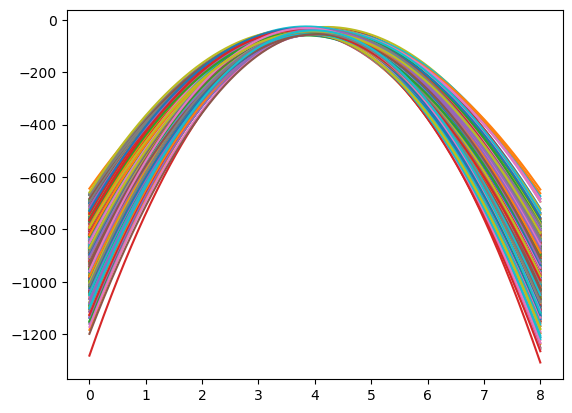

In [421]:
#Repeat (2) with all $1000$ boostrap datasets to find the distribution of the sample mean. 
for i in range(len(boots)):
    plt.plot(xgrid,lnL_mugrid(boots[i],xgrid))

In [422]:
#determining optimum mu

bestmus = []
for i in range(len(boots)):
    lnLdat = lnL_mugrid(data=boots[i],mu=xgrid) #compute ln Likelihoods for ith dataset in list of bootstrapped datasets
    lnLmax = lnLdat.max()                       #determine max ln Likelihood
    muindex = np.where(lnLdat == lnLmax)        #determine corresponding index of max lnL
    muopt = xgrid[muindex][0]                   #determine mu value that generated said index
    #print(muopt)
    bestmus.append(muopt)                       #make list of bestmus

#print('Maximum ln Likelihood:', lnLmax)
#print('Optimum mu:', muopt)
    
print(bestmus)


[3.803803803803804, 3.8118118118118116, 3.883883883883884, 3.73973973973974, 3.915915915915916, 3.883883883883884, 4.052052052052052, 3.947947947947948, 3.995995995995996, 3.7877877877877877, 3.8998998998999, 3.883883883883884, 3.8998998998999, 3.9319319319319317, 4.1001001001001, 3.8518518518518516, 4.18018018018018, 3.963963963963964, 3.97997997997998, 3.8278278278278277, 3.987987987987988, 3.9319319319319317, 4.012012012012012, 3.947947947947948, 3.955955955955956, 3.8918918918918917, 3.883883883883884, 3.963963963963964, 4.052052052052052, 3.875875875875876, 3.971971971971972, 3.835835835835836, 3.6996996996997, 3.8118118118118116, 3.97997997997998, 3.9319319319319317, 3.8918918918918917, 3.971971971971972, 3.795795795795796, 3.93993993993994, 3.8678678678678677, 4.004004004004004, 4.028028028028028, 3.915915915915916, 3.923923923923924, 3.803803803803804, 3.987987987987988, 3.97997997997998, 4.092092092092092, 3.7877877877877877, 3.995995995995996, 3.8918918918918917, 3.9399399399

3.9179920346060557 0.09481084100510954


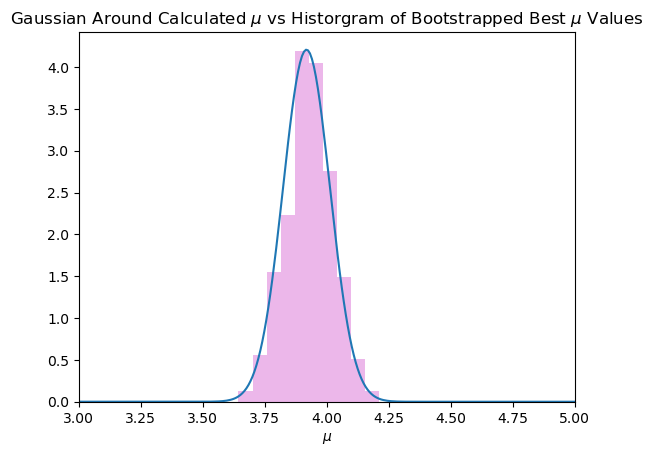

In [440]:
#Plot a normalized histogram of these bootstrap means
#and overplot a Gaussian pdf with the mean and std found in (1). 
#Do these agree?

plt.hist(bestmus,bins=10,density=True,alpha=0.5,color='orchid') #histogram of optimal sample means from bootstrapped datasets

distG = scipy.stats.norm(datmean,uncmean) #Gaussian 
plt.plot(xgrid,distG.pdf(xgrid))
plt.xlim(3,5)
plt.title('Gaussian Around Calculated $\mu$ vs Historgram of Bootstrapped Best $\mu$ Values')
plt.xlabel('$\mu$')

print(datmean,uncmean)

### Part 6

In [ ]:
#Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. 
#Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.



### Part 7

In [ ]:
#Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?


### Part 8

In [ ]:
#Using the $1000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.


### Part 9

In [ ]:
#Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?